## Requirements of Topic C. Sentiment Analysis

Text sentiment analysis (TSA) refers to identification of sentiments, usually positive or negative, expressed in text or document. One may want to develop deep learning techniques for TSA:
1. To deal with domain adaptation, that is, how can one adapt a network train on one domain to work in another domain
2. To compare the performance of different Transformers architectures
3. To deal with small datasets, that is, with insufficient number of training samples


References:
1. T. Gui et al., “Long Short-Term Memory with Dynamic Skip Connections,” Proc. AAAI Conf. Artif. Intell., 2019, doi: 10.1609/aaai.v33i01.33016481.
2. A. L. Maas, R. E. Daly, P. T. Pham, D. Huang, A. Y. Ng, and C. Potts, “Learning word vectors for sentiment analysis,” in ACL-HLT 2011 - Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies, 2011.
3. X. Zhang, J. Zhao, and Y. Lecun, “Character-level convolutional networks for text classification,” in Advances in Neural Information Processing Systems, 2015.

<a id="content"></a>
## Contents
* [0. Dependencies](#dependencies)
* [1. Dataset Processing & Exploration](#dataset)
    * [1.1. Loading Data](#loading)
    * [1.2. Text Cleaning](#cleaning)
    * [1.3. Dataset Visualization](#visualization)
    * [1.4. Vectorization](#vectorization)
* [2. Models](#models)
    * [2.1. Naive Bayes Classfication](#naive)
    * [2.2. Long Short Term Memory (LSTM) Classification](#lstm)
    * [2.3. MultiChannelCNN](#mchcnn)
    * [2.4. CNN_LSTM](#cnnlstm)
* [3. Transformers](#transformers)
    * [3.1. DistilBERT](#distilbert)


TODO:
1. Add ROBERTA & BERT for stanford tree bank
2. Find a way to incorporate highlighter

<a id="dependencies"></a>
## [0. Dependencies](#content)

Import necessary libraries.
    

In [1]:
!pip install langdetect==1.0.9
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=d9b9d62d6a05d60b844eceacd4cdf3e6c74a7db5e5f1b1afbc54abb0da3b9c4d
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
import pandas as pd
import numpy as np
import shutil # OS interaction
import pickle # For saving and reloading data and models
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For text cleaning - language detection
from langdetect import detect
from langdetect import DetectorFactory

# For text cleaning - basic cleaning
from bs4 import BeautifulSoup # For removing html components
import string # For removing punctuation
import re 

# For text preprocessing - stem & lemmatize
import nltk
from nltk.stem import PorterStemmer
#from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# For text visualization
from collections import Counter # Count word frequency
# For word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.mode.chained_assignment = None


# For dataset split
from sklearn.model_selection import train_test_split

# For text vectorization and label
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Base Model
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

# For neural network definition
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model

# For MCHCNN
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, concatenate, Dense, Embedding, Dropout

# For LSTM 
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import LSTM, SpatialDropout1D

# For CNN-LSTM
from tensorflow.keras.layers import BatchNormalization, Bidirectional

# For DistilBERT
from transformers import DistilBertTokenizer, TFAutoModel, AdamWeightDecay

# For TextBlob
from textblob import TextBlob

# For hyper-parameter selection
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# For easy progress bar
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

<a id="dataset"></a>
## [1. Dataset Processing & Exploration](#content)

Datasets given by requirements:
1. [Stanford Sentiment Treebank(Not in use)](https://www.kaggle.com/atulanandjha/stanford-sentimenttreebank-v2-sst2)
2. [IMDB movie review dataset(Used in the notebook)](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50kmovie-reviews)
3. [YELP review dataset(Not in use)](http://xzh.me/docs/charconvnet.pdf)

<a id="loading"></a>
### [1.1. Loading Data](#content)
We load the dataset directly from kaggle using pandas.

In [3]:
# Load the dataset
# Please replace the path with the actual path to the IMDB dataset
data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


<a id="cleaning"></a>
### [1.2. Text Cleaning](#content)

In the text cleaning section, we take the following steps on the entire dataset:

1. Language Recognition: To remove non-English contents
2. Basic Cleaning: Removes stopwords, special characters, single characters, multiple spaces, possible emojis and links
3. Stemming & Lemmatization: As different models might have different requirements on input, we want to examine the result of applying stemming and lemmatization on different models to find the best result.


#### Language detection

Using [langdetect](https://pypi.org/project/langdetect/) packet to remove non-english content from the review

In [4]:
DetectorFactory.seed = 48 # set seed for reproduction

def language_detection(x:str):
    text = x.split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            lang = "unknown"
            pass
    return lang

data['language'] = data['review'].progress_apply(language_detection)
data['language'].value_counts()

100%|██████████| 50000/50000 [06:44<00:00, 123.73it/s]


language
en    49999
id        1
Name: count, dtype: int64

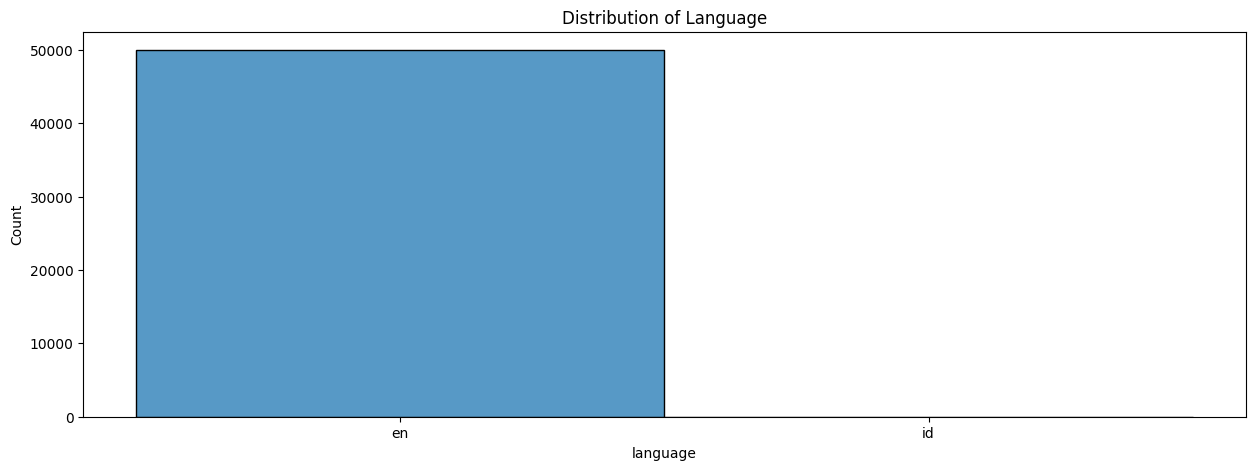

In [5]:
#plot the distribution of language
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=data['language'])
plt.title("Distribution of Language")
plt.show()

Since there's only 1 review identified as non-english, we assume the dataset is english-based, and no non-English content is present.

#### Basic Cleaning
Removes stopwords, special characters, single characters and multiple spaces.



In [6]:
# Text preprocessing
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()



def clean_text(text):
    # Uniode text
    if isinstance(text, float):
        text = str(text)
    if isinstance(text, int):
        text = str(text)
    if not isinstance(text, str):
        text = text.decode('utf-8', 'ignore')
    
    text = text.lower() # Lowercase text
    
    text = re.sub(r'\W', ' ', text) # Remove all the special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove all single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) # Remove single characters from the start
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Substituting multiple spaces with single space
    text = re.sub(r'#', '', text)# Remove hashtag sign
    
    # Remove possible links
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    
    # Remove emojis
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols                                                                         
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r'',text)
    
    return text

def decontracted(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"can\'t", "cannot", text)
    text = re.sub(r"it\'s", "it is", text)
    text = re.sub(r"there\'s", "there is", text)
    text = re.sub(r"nothing\'s", "nothing is", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\“", "", text)
    text = re.sub(r"\”", "", text)
    text = re.sub(r"\…", "", text)
    return text

def remove_punc(text):
    text =  text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split()])
    return text

additional_stopwords = ["``","''","br",'--', 'u', 'b', 'c', 'd', 'x', 'xf', 'f', 'p', 'xb', 'e']
STOPWORDS = set(stopwords.words('english')+additional_stopwords)
def remove_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # Remove stopwords from text
    return text

In [7]:
data['cleaned_review'] = data['review'].progress_apply(strip_html).apply(clean_text).apply(decontracted).apply(remove_punc).apply(remove_stopwords)
data.head()

100%|██████████| 50000/50000 [00:12<00:00, 4072.50it/s]


,review,sentiment,language,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,en,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,en,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,en,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,en,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,en,petter mattei love time money visually stunnin...


#### Stemming
Stemming adheres to predefined rules to remove suffixes like "ing," "ed," "es," and others. While it's fast, it may result in peculiar words. Doing stemming helps reduce noise in the corpus

In [8]:
def stem_text(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    stem = ''
    
    for i in x:
        stem += stemmer.stem(i) + ' '
        
    return stem

data['cleaned_stemmed_review'] = data['cleaned_review'].progress_apply(stem_text)
data.head()

100%|██████████| 50000/50000 [05:18<00:00, 157.17it/s]


,review,sentiment,language,cleaned_review,cleaned_stemmed_review
0,One of the other reviewers has mentioned that ...,positive,en,one reviewers mentioned watching 1 oz episode ...,one review mention watch 1 oz episod hook righ...
1,A wonderful little production. <br /><br />The...,positive,en,wonderful little production filming technique ...,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,positive,en,thought wonderful way spend time hot summer we...,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,negative,en,basically family little boy jake thinks zombie...,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,en,petter mattei love time money visually stunnin...,petter mattei love time money visual stun film...


In [9]:
print("========== number of words in the corpus ==========")

print(f"original: {data['review'].apply(lambda x: len(x.split())).sum()}")

print(f"after basic cleaning: {data['cleaned_review'].apply(lambda x: len(x.split())).sum()}")

print(f"after stemming: {data['cleaned_stemmed_review'].apply(lambda x: len(x.split())).sum()}")

========== number of words in the corpus ==========
original: 11557847
after basic cleaning: 5965854
after stemming: 5969055


After cleaning and stemming, the noise of the text corpus decreased largely

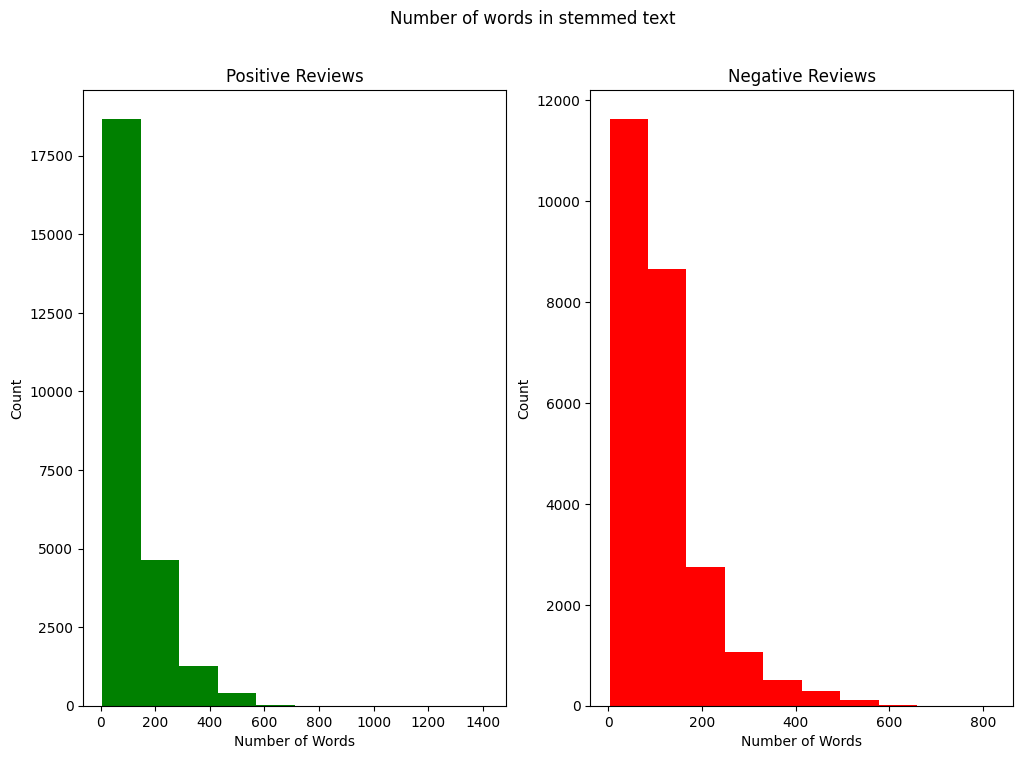

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=data[data['sentiment'] == 'positive']['cleaned_stemmed_review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=data[data['sentiment'] == 'negative']['cleaned_stemmed_review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in stemmed text')
plt.show()

<a id="visualization"></a>
### [1.3. Data Visualization](#content)

Here we do some basic data visualization to get a big picture of the dataset

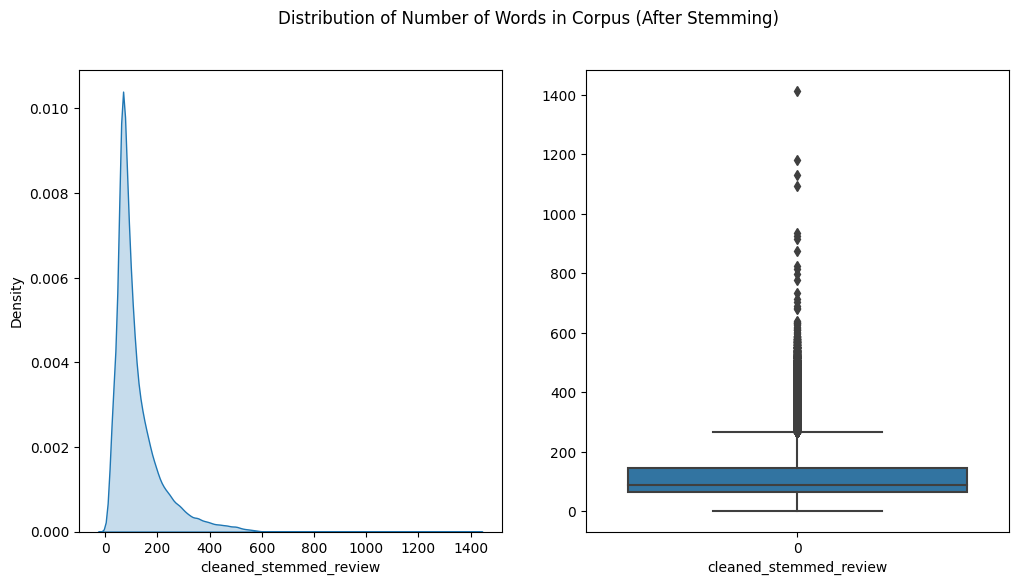

In [11]:
# Investigate word distribution
num_words_train = data['cleaned_stemmed_review'].apply(lambda x: len(x.split()))
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.kdeplot(data['cleaned_stemmed_review'].apply(lambda x: len(x.split())), fill=True, ax=axes[0])
sns.boxplot(data['cleaned_stemmed_review'].apply(lambda x: len(x.split())), ax=axes[1])
axes[1].set_xlabel("cleaned_stemmed_review")
fig.suptitle('Distribution of Number of Words in Corpus (After Stemming)')
plt.show()

In [12]:
# Find the top 25 most common words
word_list = data['cleaned_review'].str.split()
top = Counter([item for sublist in word_list for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp.columns = ['common_words','count']
temp.style.background_gradient(cmap='Blues')

,common_words,count
0,movie,87937
1,film,79674
2,one,53585
3,like,40160
4,good,29737
5,time,25100
6,even,24855
7,would,24599
8,story,23110
9,really,23089


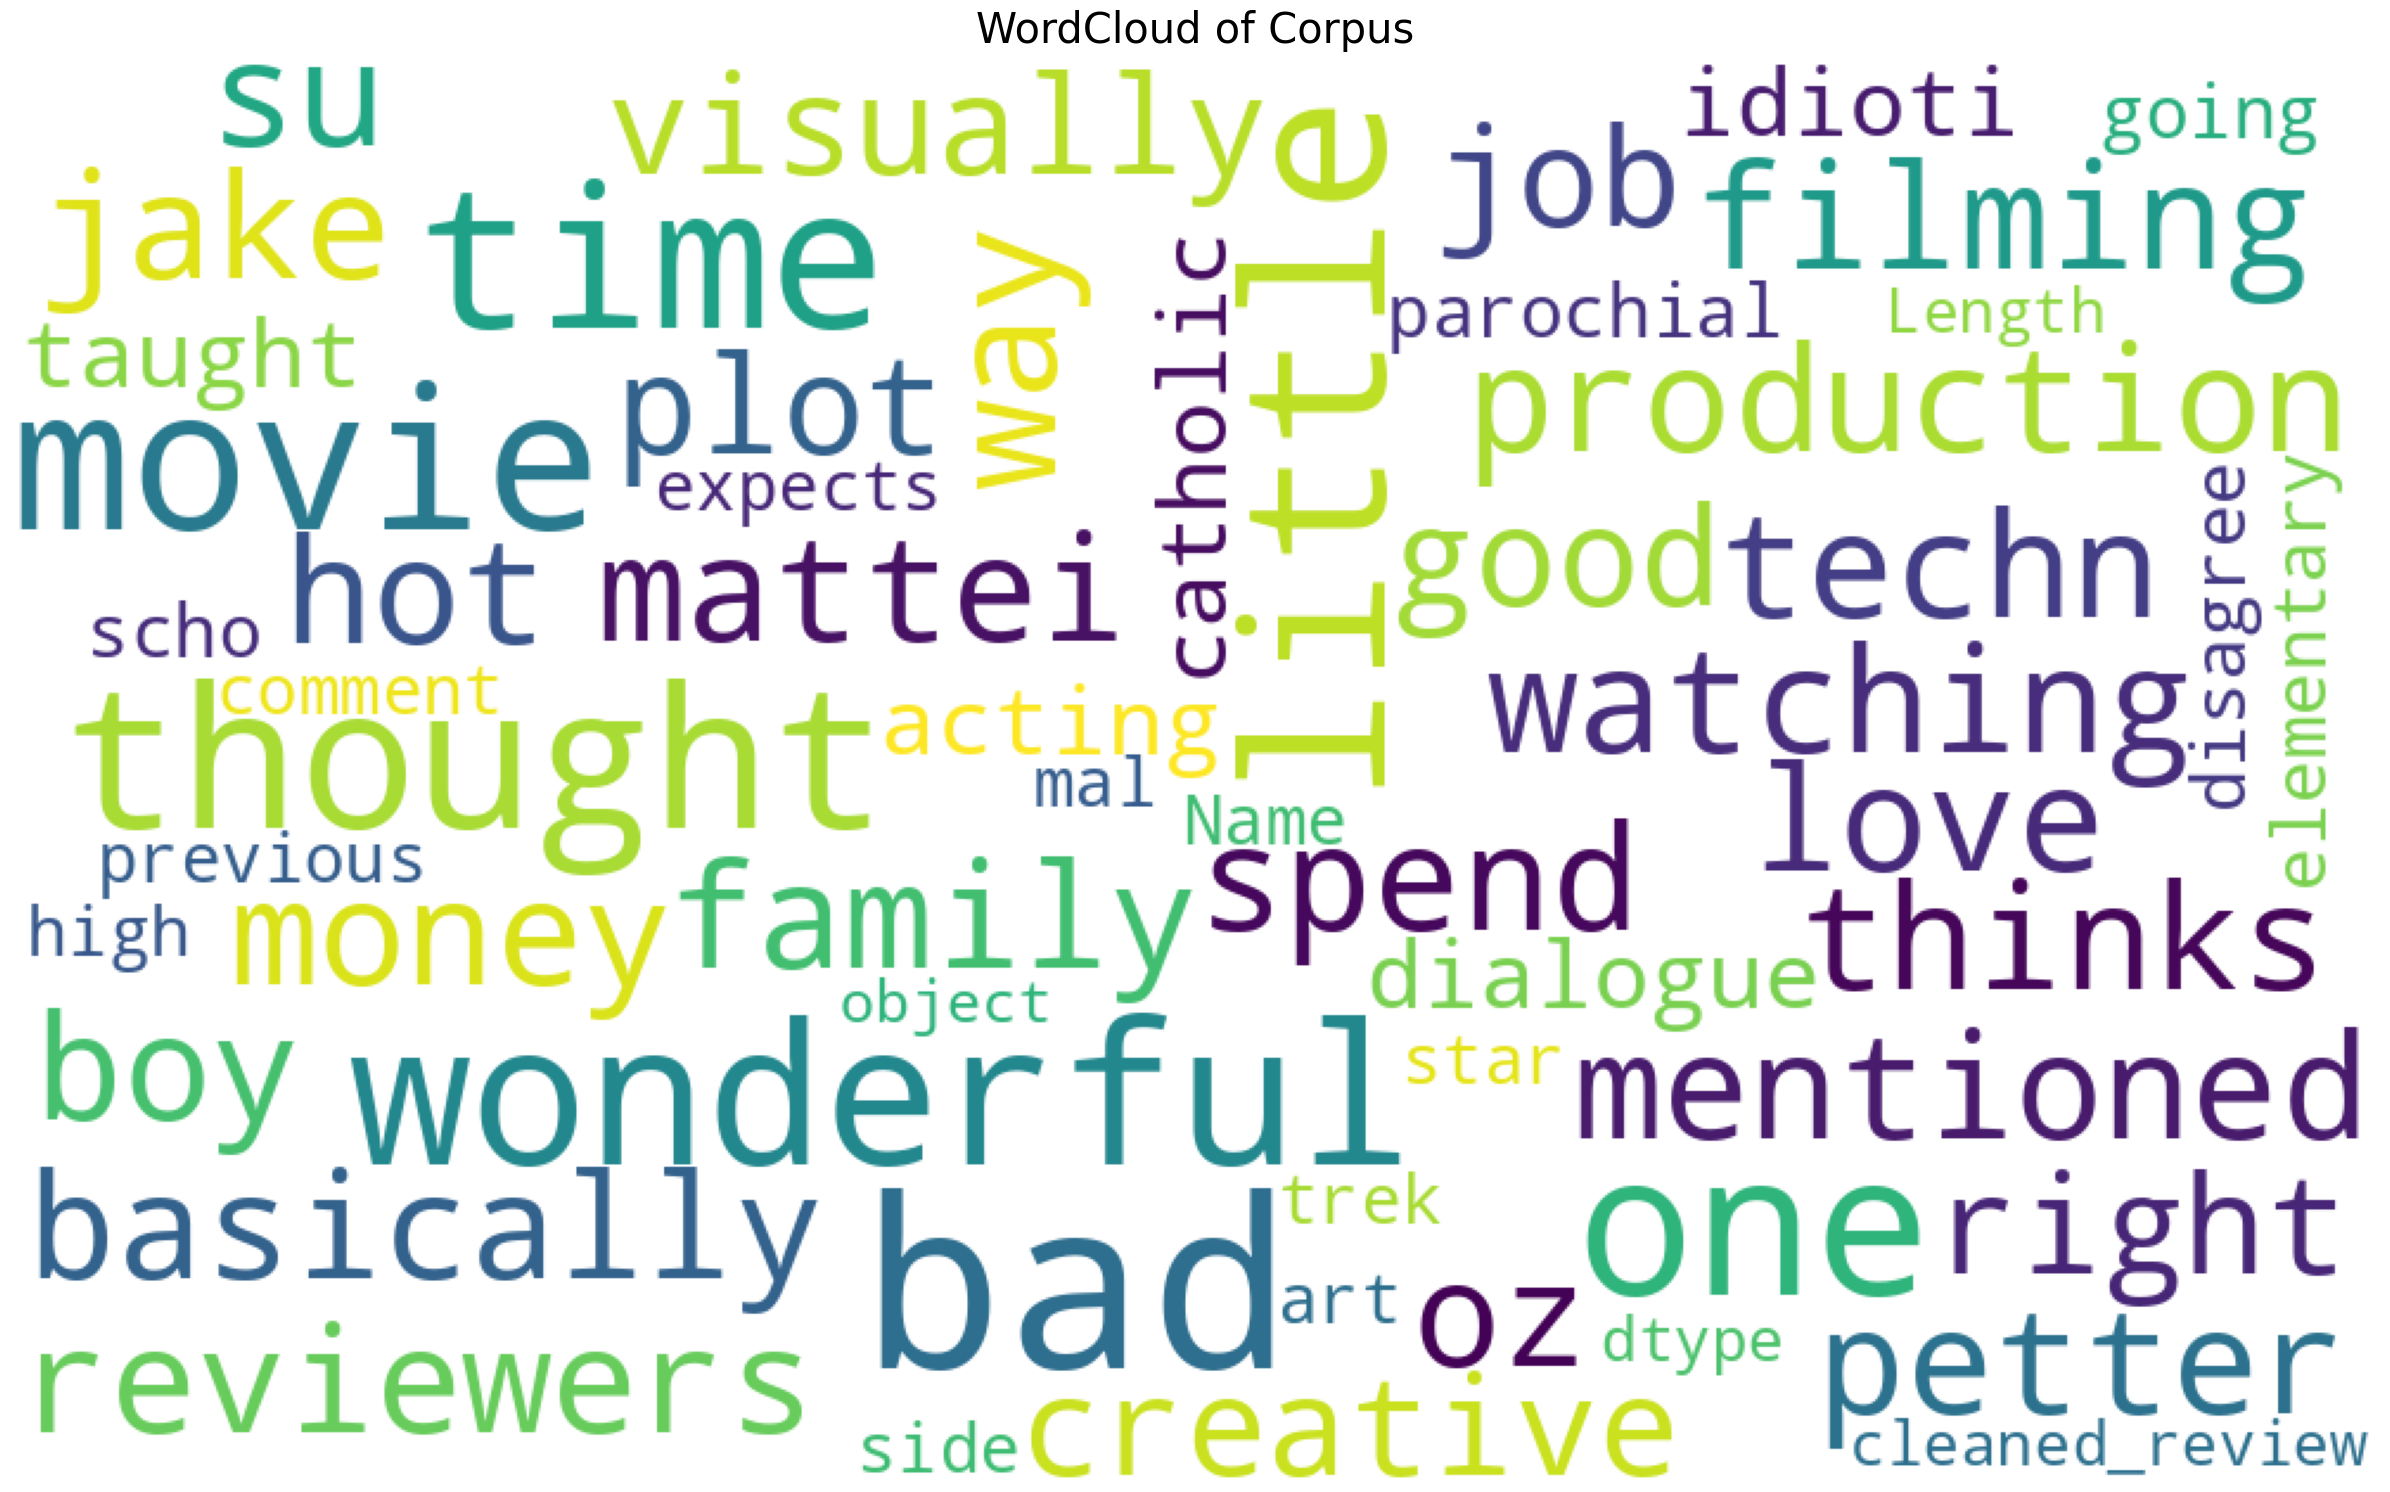

In [13]:
# Plot wordcloud
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color=color,
                    stopwords = STOPWORDS,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 5,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    
pos_mask = np.array(Image.new('RGB', (1000,600)))
plot_wordcloud(word_list, mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Corpus")

<a id="vectorization"></a>
### [1.4. Vectorization](#content)

For training with classifiers, vectorization is necessary. We are also going to split dataset into train, validation & test in this section before tokenization, and apply vector transform only on train data to avoid data leak.

#### Train, Validation, Test split

Before splitting the dataset, let's convert the sentiment column to label and examine the balanceness of the label

In [14]:
features = ['cleaned_review', 'cleaned_stemmed_review']
target='sentiment'

# Converting categorical labels to numbers.
data[target] = pd.get_dummies(data[target]).values
print('Shape of label tensor:', data[target].shape)

# Show label counts
data[target].value_counts()

Shape of label tensor: (50000,)


sentiment
False    25000
True     25000
Name: count, dtype: int64

Since the Y label is well balanced, we don't need to under/over sample to balance the dataset, let's move on to train/test/cv split

In [15]:
# Split the dataset into 0.6:0.2:0.2 by default
# Use stratify to ensure that label are still balanced after split
def split_data(X, Y, test_size=0.2, val_size = 0.2, seed=42):
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, Y,
                                                        test_size = test_size, 
                                                        random_state = seed, stratify=Y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, 
                                                        y_train_valid,
                                                        test_size = val_size/(1-test_size), 
                                                        random_state = seed, stratify=y_train_valid)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(data[features], data[target])
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_valid: {X_val.shape}")
print(f"Shape of y_valid: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (30000, 2)
Shape of y_train: (30000,)
Shape of X_valid: (10000, 2)
Shape of y_valid: (10000,)
Shape of X_test: (10000, 2)
Shape of y_test: (10000,)


#### Vectorization
In NLP, there are many text vectorization methods. We are going to apply the following techniques and collect the data for future use.

1. Index Vectorization: converts each word in the text to an index based on its position in a word index vocabulary
2. Bag of Words:
3. Tfidf: Term Frequency-Inverse Document Frequency (TF-IDF) vectorization is a method commonly used in NLP to represent text data numerically, giving more weight to words that are important within a specific document while considering their frequency across the entire corpus.

In [16]:
X_train_dict = {}
X_val_dict = {}
X_test_dict = {}

methods = ['index', 'bow', 'tfidf']

# Max number of words in each sequence, choose 600 as most of the reviews is under 600 number of words
MAX_SEQUENCE_LENGTH = 500 # Also length of feature
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# This is fixed.
EMBEDDING_DIM = 100

With index vectorization, we tokenize the cleaned texts and convert them into sequences of numbers. We then pad the sequences to make them of equal length.

In [17]:
def keras_token_transform(tokenizer, X):
    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    return X

# keras defaults to index vectorization
def index_vectorization(X_train, X_val, X_test):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index
    
    X_train_vec = keras_token_transform(tokenizer, X_train)
    X_val_vec = keras_token_transform(tokenizer, X_val)
    X_test_vec = keras_token_transform(tokenizer, X_test)
    return X_train_vec, X_val_vec, X_test_vec

method = methods[0]
for feature in features:
    X_train_dict[f'{method}_{feature}'], X_val_dict[f'{method}_{feature}'], X_test_dict[f'{method}_{feature}'] = index_vectorization(X_train[feature].values, X_val[feature].values, X_test[feature].values) 
    #print(f"First example of {feature} after {method} vectorization")
    #print(X_train_dict[f'{method}_{feature}'][0])

With bag of words vectorization

In [18]:
def bow_vectorizaion(X_train, X_val, X_test):
    clf = CountVectorizer(ngram_range=(1,2), max_features=MAX_SEQUENCE_LENGTH).fit(X_train)
    X_train_vec =  clf.transform(X_train).toarray()
    X_val_vec = clf.transform(X_val).toarray()
    X_test_vec = clf.transform(X_test).toarray()
    
    return X_train_vec, X_val_vec, X_test_vec

method = methods[1]
for feature in features:
    X_train_dict[f'{method}_{feature}'], X_val_dict[f'{method}_{feature}'], X_test_dict[f'{method}_{feature}'] = bow_vectorizaion(X_train[feature], X_val[feature], X_test[feature])
    #print(f"First example of {feature} after {method} vectorization")
    #print(X_train_dict[f'{method}_{feature}'][0])

With tfidf vectorization

In [19]:
def tfidf_vectorizaion(X_train, X_val, X_test):
    clf = CountVectorizer(ngram_range=(1,2), max_features=MAX_SEQUENCE_LENGTH).fit(X_train)
    X_train_cnt_vec =  clf.transform(X_train)
    X_valid_cnt_vec = clf.transform(X_val)
    X_test_cnt_vec = clf.transform(X_test)
    
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cnt_vec)
    X_train_vec = tf_transformer.transform(X_train_cnt_vec).toarray()
    X_val_vec = tf_transformer.transform(X_valid_cnt_vec).toarray()
    X_test_vec = tf_transformer.transform(X_test_cnt_vec).toarray()
    
    return X_train_vec, X_val_vec, X_test_vec

method = methods[2]
for feature in features:
    X_train_dict[f'{method}_{feature}'], X_val_dict[f'{method}_{feature}'], X_test_dict[f'{method}_{feature}'] = tfidf_vectorizaion(X_train[feature], X_val[feature], X_test[feature])
    #print(f"First example of {feature} after {method} vectorization")
    #print(X_train_dict[f'{method}_{feature}'][0])

In [20]:
for method in methods:
    for feature in features:
        print(f"Shape of {feature} X_train after {method} vectorization", X_train_dict[f'{method}_{feature}'].shape)

Shape of cleaned_review X_train after index vectorization (30000, 500)
Shape of cleaned_stemmed_review X_train after index vectorization (30000, 500)
Shape of cleaned_review X_train after bow vectorization (30000, 500)
Shape of cleaned_stemmed_review X_train after bow vectorization (30000, 500)
Shape of cleaned_review X_train after tfidf vectorization (30000, 500)
Shape of cleaned_stemmed_review X_train after tfidf vectorization (30000, 500)


In [21]:
def save_data(data_dict, file_name):
    # Open the file in binary write mode and save the dictionary
    with open(file_name, 'wb') as file:
        pickle.dump(data_dict, file)

def load_data(file_name):
    loaded_data = {}
    # Open the file in binary read mode and load the dictionary
    with open(file_name, 'rb') as file:
        loaded_data = pickle.load(file)
    return loaded_data

For fast reloading of the data

In [22]:
# Save vectorized data
save_data(X_train_dict, "x_train_dict.pkl")
save_data(X_test_dict, "x_test_dict.pkl")
save_data(X_val_dict, "x_val_dict.pkl")

In [23]:
X_train_dict = load_data("x_train_dict.pkl")
X_test_dict = load_data("x_test_dict.pkl")
X_val_dict = load_data("x_val_dict.pkl")

<a id="models"></a>
## [2. Models](#content)

In this section, we will use Naive Bayes as the base model to compare neural network performance

<a id="naive"></a>
### [2.1. Naive Bayes Classification](#content)

In [24]:
def print_eval(y_test, result, ax, title):
    
    confuse = metrics.confusion_matrix(y_test, result)
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    sns.heatmap(confuse, annot = True, fmt='d', ax=ax)
    
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score = metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)
    
    print(f"---------- Evaluation Metrics for {title} ----------\n")
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}\n'.format(average_precision))

def naive_bayes_train_test(x_train, y_train, x_test, y_test, ax, title):

    model = MultinomialNB().fit(x_train, y_train)
    result = model.predict(x_test)
    
    print_eval(y_test, result, ax, title)

---------- Evaluation Metrics for index_cleaned_review ----------

F1 score: 0.635
Precision score: 0.503
Recall score: 0.862
Average precision-recall score: 0.503

---------- Evaluation Metrics for index_cleaned_stemmed_review ----------

F1 score: 0.634
Precision score: 0.503
Recall score: 0.857
Average precision-recall score: 0.502

---------- Evaluation Metrics for bow_cleaned_review ----------

F1 score: 0.814
Precision score: 0.829
Recall score: 0.799
Average precision-recall score: 0.763

---------- Evaluation Metrics for bow_cleaned_stemmed_review ----------

F1 score: 0.816
Precision score: 0.828
Recall score: 0.804
Average precision-recall score: 0.764

---------- Evaluation Metrics for tfidf_cleaned_review ----------

F1 score: 0.819
Precision score: 0.836
Recall score: 0.803
Average precision-recall score: 0.769

---------- Evaluation Metrics for tfidf_cleaned_stemmed_review ----------

F1 score: 0.819
Precision score: 0.835
Recall score: 0.804
Average precision-recall scor

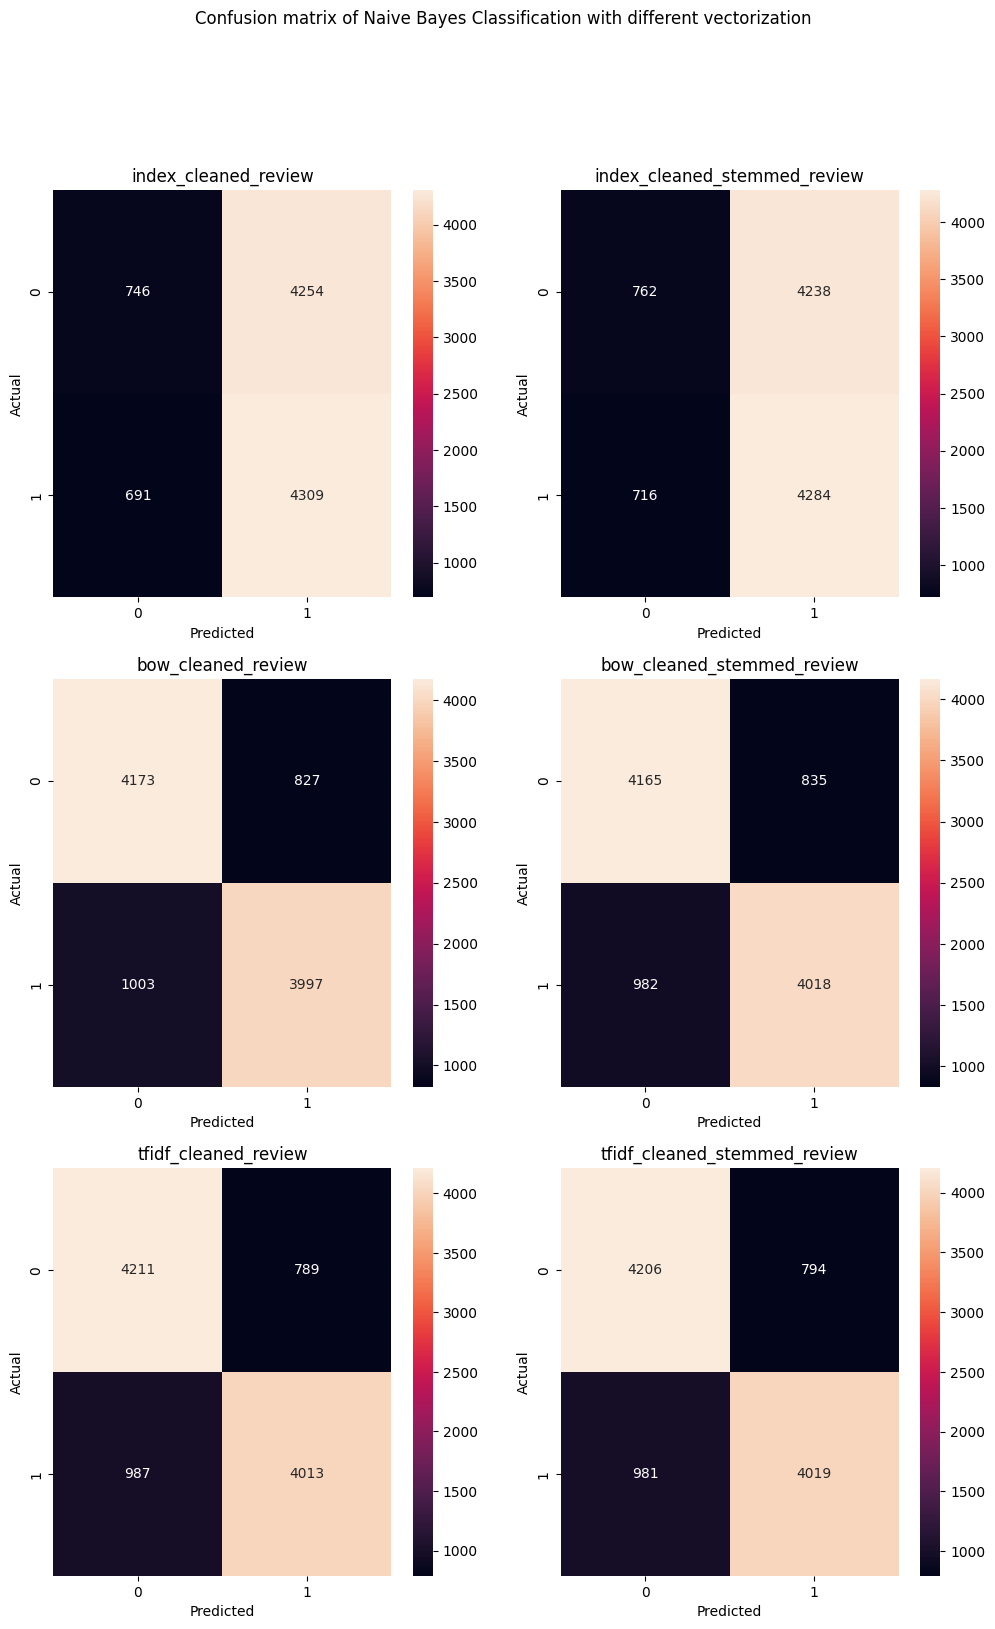

In [25]:
fig, axes = plt.subplots(len(methods), len(features), figsize=(6*len(features), 6*len(methods)))
for i in range(len(methods)):
    for j in range(len(features)):
        method = methods[i]
        feature = features[j]
        naive_bayes_train_test(X_train_dict[f'{method}_{feature}'], y_train, X_test_dict[f'{method}_{feature}'], y_test, ax=axes[i,j], title=f'{method}_{feature}')
        
fig.suptitle(f"Confusion matrix of Naive Bayes Classification with different vectorization")
plt.show()

NaiveBayes works the best with stemmed text using tfidf vectorization, which also confirmed our assumption that stemming text will reduce the noise in the data, which in turn improves model performance

<a id="lstm"></a>
### [2.2. Long Short Term Memory (LSTM) Classification](#content)

Since we are running high-dimensional large dataset, using TPU will significantly reduce training time, we are using the TPU on kaggle and training on stemmed text with tfidf vectorization

In [26]:
# utility function for plotting
def history_plot(history):
    
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
    # Get the training loss and validation loss from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the training accuracy and validation accuracy from the history object
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot the training and validation loss and accuracy on a single ax
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(train_accuracy, label='Training Accuracy')
    ax2.plot(val_accuracy, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
def predict_eval(model, X_test, y_test, title):
    # Generate predictions for the test dataset and plot cf_mtx
    result = model.predict(X_test)
    result = result>0.5

    fig, ax = plt.subplots(1,1,figsize=(6,6))
    print_eval(y_test, result, ax, title)
    plt.show()

In [27]:
try:
    tpu_cluster = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU', tpu_cluster.master())
except ValueError:
    tpu_cluster = None # It assigns None to the tpu_cluster variable, indicating that no TPU is available

if tpu_cluster: # is not None
    tf.config.experimental_connect_to_cluster(tpu_cluster)
    tf.tpu.experimental.initialize_tpu_system(tpu_cluster)
    dist_strategy = tf.distribute.TPUStrategy(tpu_cluster) # use a distribution strategy related to the presence of TPU 
else: # is None
    dist_strategy = tf.distribute.get_strategy() # use a distribution strategy related to the absence of TPU 

print('The number of Replica involved in strategy :', dist_strategy.num_replicas_in_sync)

The number of Replica involved in strategy : 1


In [28]:
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [29]:
# Create the model
with dist_strategy.scope():
    lstm_model_index = create_lstm_model()

lstm_model_index.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 500, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________


In [30]:
EPOCHS = 10
BATCH_SIZE = 32 * dist_strategy.num_replicas_in_sync # The number of input sequences in each batch
STEPS_PER_EPOCH =round(X_train_dict['index_cleaned_stemmed_review'].shape[0] / BATCH_SIZE) # The numebr of batches
ES = EarlyStopping(monitor='val_loss', patience=5)
MC = ModelCheckpoint('/kaggle/working/model_weights.h5', monitor='val_loss', save_best_only=True) 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = lstm_model_index.fit(X_train_dict['index_cleaned_stemmed_review'],
                         y_train,
                         epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_val_dict['index_cleaned_stemmed_review'], y_val),
                        callbacks=[ES, MC, LR]
)

Epoch 1/10
938/938 [==============================] - 731s 775ms/step - loss: 0.3550 - accuracy: 0.8449 - val_loss: 0.3649 - val_accuracy: 0.8485 - lr: 0.0010
Epoch 2/10
938/938 [==============================] - 726s 774ms/step - loss: 0.2008 - accuracy: 0.9252 - val_loss: 0.2947 - val_accuracy: 0.8797 - lr: 0.0010
Epoch 3/10
938/938 [==============================] - 706s 752ms/step - loss: 0.1391 - accuracy: 0.9498 - val_loss: 0.3848 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 4/10
938/938 [==============================] - 709s 755ms/step - loss: 0.1020 - accuracy: 0.9638 - val_loss: 0.3726 - val_accuracy: 0.8738 - lr: 0.0010
Epoch 5/10
938/938 [==============================] - 726s 773ms/step - loss: 0.0468 - accuracy: 0.9855 - val_loss: 0.4890 - val_accuracy: 0.8808 - lr: 2.0000e-04
Epoch 6/10
938/938 [==============================] - 742s 791ms/step - loss: 0.0318 - accuracy: 0.9905 - val_loss: 0.4999 - val_accuracy: 0.8815 - lr: 2.0000e-04
Epoch 7/10
938/938 [==================

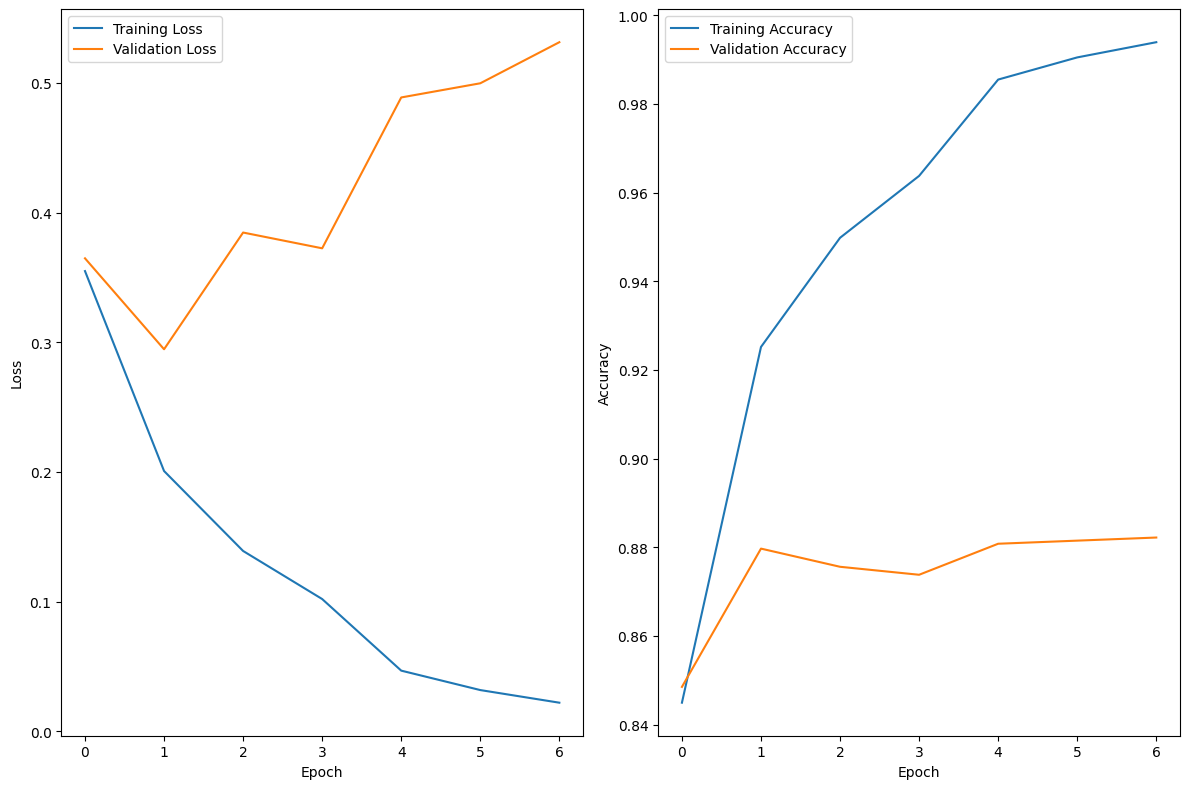

In [31]:
# Show Plot
history_plot(history)

313/313 [==============================] - 33s 103ms/step
---------- Evaluation Metrics for lstm_index_cleaned_stemmed_review ----------

F1 score: 0.877
Precision score: 0.876
Recall score: 0.878
Average precision-recall score: 0.830



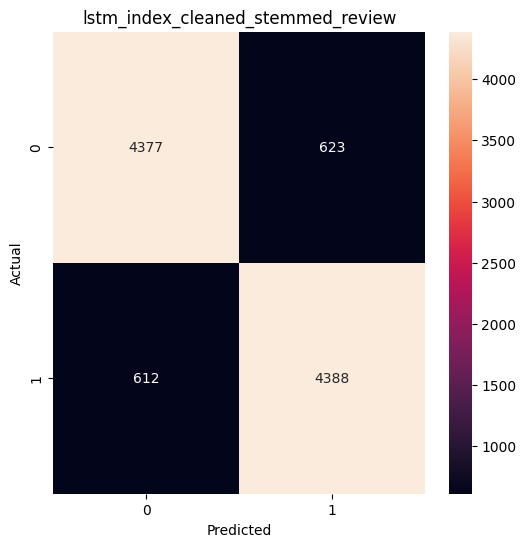

In [32]:
# Evaluation with test set
predict_eval(lstm_model_index, X_test_dict['index_cleaned_stemmed_review'], y_test, 'lstm_index_cleaned_stemmed_review')

We define an LSTM model, compile it, and then train it using our training data.

<a id="mchcnn"></a>
### [2.3. MultiChannelCNN](#content)

In [33]:
def create_mchcnn_model():
    input1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding1 = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(input1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(conv1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)

    input2 = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding2 = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(input2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(conv2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2= Flatten()(pool2)

    input3 = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding3 = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(input3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)

    input4 = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding4 = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(input4)
    conv4 = Conv1D(filters=32, kernel_size=10, activation='relu')(embedding4)
    conv4 = Conv1D(filters=32, kernel_size=10, activation='relu')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling1D(pool_size=2)(drop4)
    flat4 = Flatten()(pool4)

    conc = concatenate([flat1, flat2, flat3, flat4])
    dense1 = Dense(128, activation='relu')(conc)
    drop1 = Dropout(0.5)(dense1)
    output = Dense(1, activation='sigmoid')(drop1)

    multi_channel_cnn = Model(inputs=[input1, input2, input3, input4], outputs=output)
    multi_channel_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return multi_channel_cnn

with dist_strategy.scope():
    multi_channel_cnn = create_mchcnn_model()

multi_channel_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 500)]        0           []                               
                                                                                              

In [34]:
X_train_selected = X_train_dict['index_cleaned_stemmed_review']
X_val_selected = X_val_dict['index_cleaned_stemmed_review']
EPOCHS = 10
BATCH_SIZE = 32 * dist_strategy.num_replicas_in_sync # The number of input sequences in each batch
STEPS_PER_EPOCH =round(X_train_selected.shape[0] / BATCH_SIZE) # The numebr of batches
ES = EarlyStopping(monitor='val_loss', patience=5)
MC = ModelCheckpoint('/kaggle/working/model_weights.h5', monitor='val_loss', save_best_only=True) 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = multi_channel_cnn.fit(
    [X_train_selected, X_train_selected, X_train_selected, X_train_selected],
    y_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    validation_data=([X_val_selected, X_val_selected, X_val_selected, X_val_selected], y_val),
    callbacks=[ES, MC, LR]
)

Epoch 1/10
938/938 [==============================] - 395s 418ms/step - loss: 0.3614 - accuracy: 0.8305 - val_loss: 0.2621 - val_accuracy: 0.8974 - lr: 0.0010
Epoch 2/10
938/938 [==============================] - 380s 405ms/step - loss: 0.1568 - accuracy: 0.9429 - val_loss: 0.2611 - val_accuracy: 0.8943 - lr: 0.0010
Epoch 3/10
938/938 [==============================] - 381s 406ms/step - loss: 0.0640 - accuracy: 0.9770 - val_loss: 0.3759 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/10
938/938 [==============================] - 404s 431ms/step - loss: 0.0302 - accuracy: 0.9898 - val_loss: 0.5204 - val_accuracy: 0.8792 - lr: 0.0010
Epoch 5/10
938/938 [==============================] - 411s 438ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.5581 - val_accuracy: 0.8854 - lr: 2.0000e-04
Epoch 6/10
938/938 [==============================] - 419s 446ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.6785 - val_accuracy: 0.8850 - lr: 2.0000e-04
Epoch 7/10
938/938 [==================

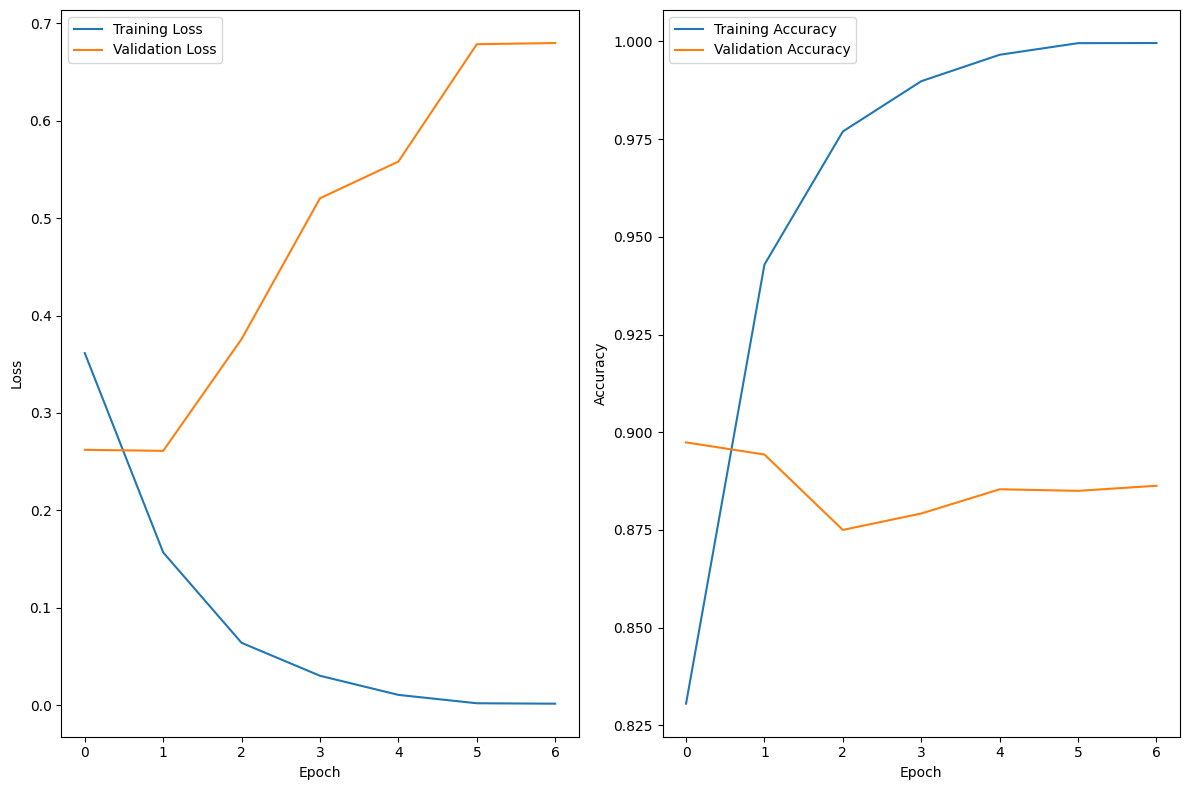

In [35]:
# Show Plot
history_plot(history)

313/313 [==============================] - 18s 56ms/step
---------- Evaluation Metrics for mchcnn_index_cleaned_stemmed_review ----------

F1 score: 0.882
Precision score: 0.898
Recall score: 0.867
Average precision-recall score: 0.845



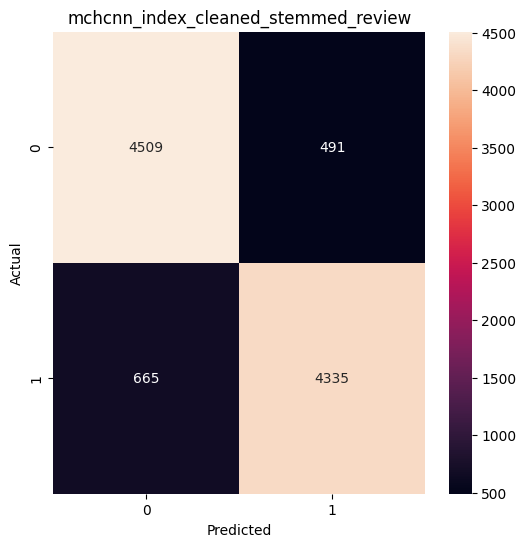

In [36]:
# Evaluate with test set
X_test_selected = X_test_dict['index_cleaned_stemmed_review']
predict_eval(multi_channel_cnn,  [X_test_selected, X_test_selected, X_test_selected, X_test_selected], y_test, 'mchcnn_index_cleaned_stemmed_review')

In [37]:
# TODO: If result of lstm+tfidf is better than lstm+index+embedding, then use tfidf for cnn as well

<a id="cnnlstm"></a>
### [2.4. CNN_LSTM](#content)

https://www.kaggle.com/code/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert

In [38]:
# TODO: Add code for CNN_LSTM
'''
def cnn_lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()
''' 
    
def create_cnn_lstm_model(tfidf=False):
    model = Sequential()
    if not tfidf:
        model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv1D(32,5,activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(2))
    model.add(Bidirectional(LSTM(128,return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

with dist_strategy.scope():
    cnn_lstm_model_index = create_cnn_lstm_model()

cnn_lstm_model_index.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 100)          5000000   
                                                                 
 batch_normalization (BatchN  (None, 500, 100)         400       
 ormalization)                                                   
                                                                 
 dropout_5 (Dropout)         (None, 500, 100)          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 496, 32)           16032     
                                                                 
 dropout_6 (Dropout)         (None, 496, 32)           0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 248, 32)          0         
 1D)                                                  

In [39]:
EPOCHS = 10
BATCH_SIZE = 32 * dist_strategy.num_replicas_in_sync # The number of input sequences in each batch
STEPS_PER_EPOCH =round(X_train_dict['index_cleaned_stemmed_review'].shape[0] / BATCH_SIZE) # The numebr of batches
ES = EarlyStopping(monitor='val_loss', patience=5)
MC = ModelCheckpoint('/kaggle/working/model_weights.h5', monitor='val_loss', save_best_only=True) 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = cnn_lstm_model_index.fit(X_train_dict['index_cleaned_stemmed_review'],
                         y_train,
                         epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_val_dict['index_cleaned_stemmed_review'], y_val),
                        callbacks=[ES, MC, LR]
)

Epoch 1/10
938/938 [==============================] - 1254s 1s/step - loss: 0.3970 - accuracy: 0.8102 - val_loss: 0.2750 - val_accuracy: 0.8934 - lr: 0.0010
Epoch 2/10
938/938 [==============================] - 1248s 1s/step - loss: 0.2020 - accuracy: 0.9242 - val_loss: 0.2611 - val_accuracy: 0.8945 - lr: 0.0010
Epoch 3/10
938/938 [==============================] - 1267s 1s/step - loss: 0.1227 - accuracy: 0.9576 - val_loss: 0.2837 - val_accuracy: 0.8945 - lr: 0.0010
Epoch 4/10
938/938 [==============================] - 1273s 1s/step - loss: 0.0789 - accuracy: 0.9737 - val_loss: 0.3809 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 5/10
938/938 [==============================] - 1255s 1s/step - loss: 0.0375 - accuracy: 0.9880 - val_loss: 0.4541 - val_accuracy: 0.8932 - lr: 2.0000e-04
Epoch 6/10
938/938 [==============================] - 1249s 1s/step - loss: 0.0250 - accuracy: 0.9932 - val_loss: 0.4877 - val_accuracy: 0.8922 - lr: 2.0000e-04
Epoch 7/10
938/938 [==============================

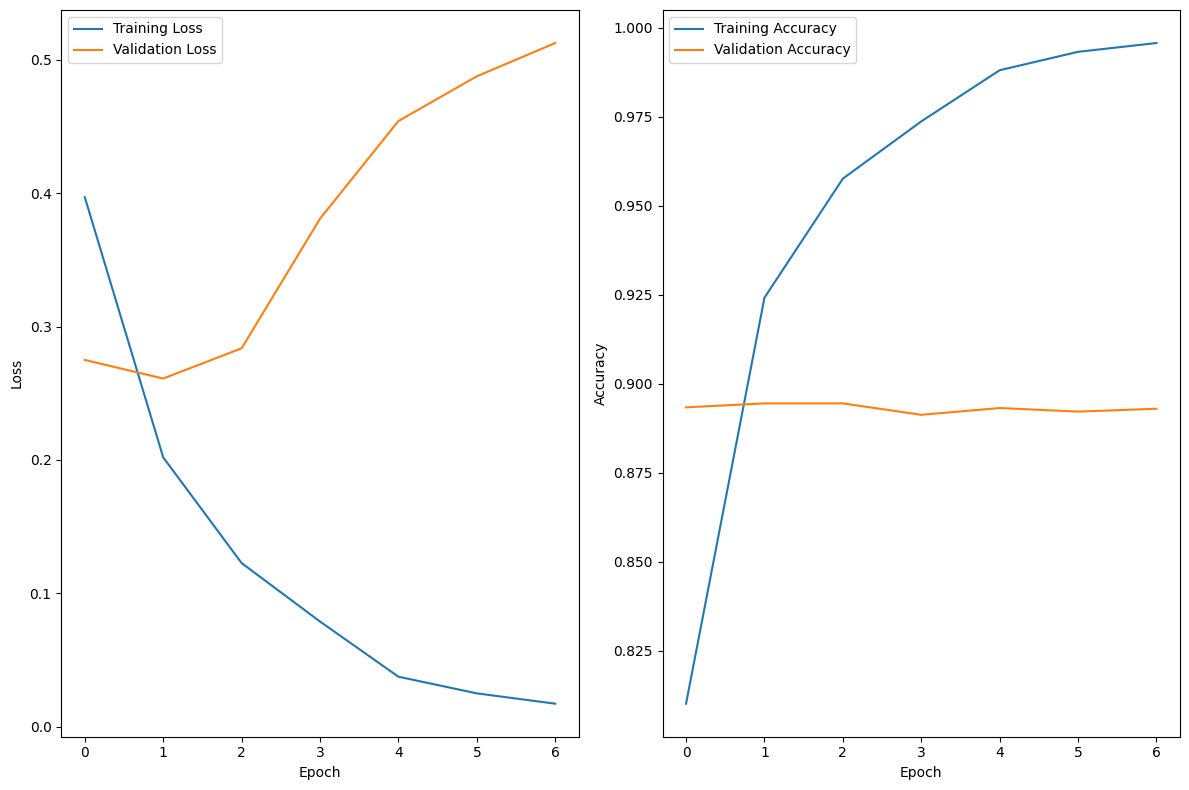

In [40]:
# Show Plot
history_plot(history)

313/313 [==============================] - 52s 162ms/step
---------- Evaluation Metrics for mchcnn_index_cleaned_stemmed_review ----------

F1 score: 0.889
Precision score: 0.892
Recall score: 0.886
Average precision-recall score: 0.847



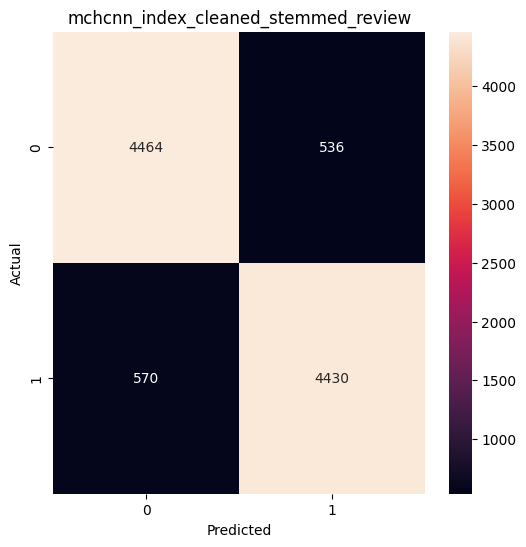

In [41]:
# Evaluate with test set
predict_eval(cnn_lstm_model_index,  X_test_dict['index_cleaned_stemmed_review'], y_test, 'mchcnn_index_cleaned_stemmed_review')

<a id="transformers"></a>
## [3. Transformers](#content)

<a id="distilbert"></a>
### [3.1. DistilBERT](#content)

As BERT is a pretrained model with its own settings and embeddings, we use the package provided tokenizor to transform data

In [42]:
# Create a DistilBertTokenizer object
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert-base-uncased")

# Save data for future reuse
save_data(tokenizer, 'tokenizer.h5')

In [43]:
tokenizer = load_data('tokenizer.h5')
tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [44]:
# Getting bert tokenizers
def bert_tokenizing(texts, tokenizer):
    """
    In text classification tasks, It is common to have varying lengths of input texts.
    To handle this variability with the transformers module, we should apply the helper method batch_encode_plus on
    a DistilBertTokenizer object to ensure that all the input texts have the same lenght.
    """
    encoded_dict = tokenizer.batch_encode_plus( # returns sequences
        texts,
        return_token_type_ids=False,
        truncation=True,
        pad_to_max_length=True, # the length of all texts will be equal to a text which has the maximum tokens
        max_length=MAX_SEQUENCE_LENGTH
    )
    return np.array(encoded_dict['input_ids']) # convert a list to an array

bert_train = bert_tokenizing(X_train['cleaned_stemmed_review'], tokenizer)
bert_val = bert_tokenizing(X_val['cleaned_stemmed_review'], tokenizer)
bert_test = bert_tokenizing(X_test['cleaned_stemmed_review'], tokenizer)

bert_train.shape, bert_val.shape, bert_test.shape

((30000, 500), (10000, 500), (10000, 500))

In [45]:
def create_bert_model(pretrained_model):
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    # we utilize a pre-trained transformer model to process input sequences or texts
    transformer_layers = pretrained_model(input_layer)[0] 
    # The CLS variable stores the representation of the [CLS] token, which is typically used as a aggregate representation of the entire input sequence.
    CLS = transformer_layers[:, 0, :] 
    drop = Dropout(.8)(CLS)
    output = Dense(1, activation='sigmoid')(drop)
    
    bert_tf = Model(inputs=[input_layer], outputs=output)
    bert_tf.compile(
        loss = 'binary_crossentropy',
        optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01),
        metrics = ['accuracy']
    )
    return bert_tf

with dist_strategy.scope():
    pretrained_model = TFAutoModel.from_pretrained(pretrained_model_name_or_path='distilbert-base-uncased')
    bert_tf = create_bert_model(pretrained_model)
    
bert_tf.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 500)]             0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 500,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dropout_27 (Dropout)        (None, 768)               0         
                                                           

In [46]:
# training the BERT model with the review data
EPOCHS = 10
BATCH_SIZE = 32 * dist_strategy.num_replicas_in_sync # The number of input sequences in each batch
STEPS_PER_EPOCH = round(bert_train.shape[0] / BATCH_SIZE) # The numebr of batches
ES = EarlyStopping(monitor='val_loss', patience=5)
MC = ModelCheckpoint('/kaggle/working/model_weights.h5', monitor='val_loss', save_best_only=True) 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

''' Don't train BERT for now
history = bert_tf.fit(
    bert_train,
    y_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    validation_data=(bert_val, y_val),
    callbacks=[ES, MC, LR]
)
'''

" Don't train BERT for now\nhistory = bert_tf.fit(\n    bert_train,\n    y_train,\n    epochs=EPOCHS,\n    steps_per_epoch=STEPS_PER_EPOCH,\n    batch_size=BATCH_SIZE,\n    validation_data=(bert_val, y_val),\n    callbacks=[ES, MC, LR]\n)\n"

In [47]:
# Show Plot
# history_plot(history)

In [48]:
# Evaluation with test set
# predict_eval(bert_tf, bert_test, y_test, 'bert_cleaned_stemmed_review')

## Conclusion

Nice job, we made it! We took a ton of IMDB movie reviews, cleaned them up, and trained an LSTM model to figure out if they were positive or negative. Pretty cool, right?

Our model did pretty well, but there's always room for improvement. Maybe we can tweak some settings, add more layers, or even use a different type of model. Plus, we can always use more or different data to train on.

Remember, what matters most is not just the final accuracy number, but understanding what's happening along the way. Don't be afraid to play around with the code and try new things. Happy coding!